In [1]:
#Author: Aaron Hertner
#Version: Python base 3.8
#Purpose: To test out the efficacy of different classification models on multi-class imbalanced datasets

In [2]:
import warnings

#graphing and util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from collections import Counter

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

#ML libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
header = ['mcg','gvh','lip','chg','aac','alm1','alm2','class']
df = pd.read_csv('../_datasets/ecoli.csv', names=header)

pd.options.display.max_columns = None
df.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [4]:
count_dic = {'cp':0,
             'im':0,
             'pp':0,
             'imU':0,
             'imL':0,
             'imS':0,
             'om':0,
             'omL':0}

for i in range(df.shape[0]):
    idx = df['class'].loc[i]
    count_dic[idx] += 1

print(count_dic)

{'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'imL': 2, 'imS': 2, 'om': 20, 'omL': 5}


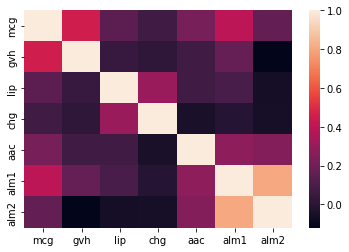

In [5]:
sb.heatmap(df.corr())

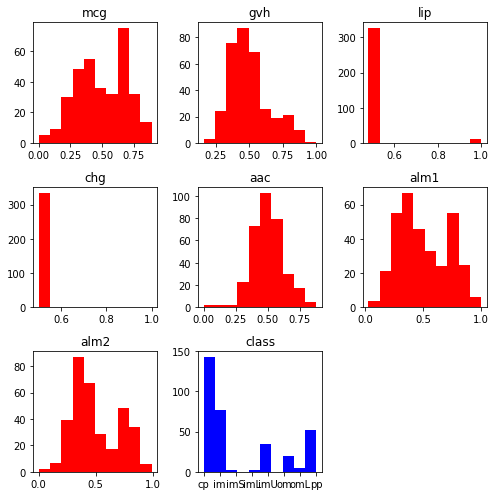

In [6]:
fig, axarr = plt.subplots(3,3, figsize=(7,7))

idx = 0
for col in df.columns:
    data = df[col]
    if col != 'class':
        axarr[idx//3][idx%3].hist(data, color='r')
    else:
        axarr[idx//3][idx%3].hist(data, color='b')
    axarr[idx//3][idx%3].set_title(col)
    idx += 1
    
axarr[idx//3][idx%3].set_axis_off()
plt.tight_layout()

In [7]:
def evaluate_model(X, Y, model):
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state=1)
    scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs = -1)
    return scores

models = []
models.append(SVC())
models.append(LogisticRegression())
models.append(DummyClassifier())
models.append(RandomForestClassifier())
models.append(GaussianProcessClassifier())

#drop classes with fewer than 5 examples
df = df[df['class'] != 'imS']
df = df[df['class'] != 'imL']
df = df[df['class'] != 'omL']

Y = df['class']
X = df.drop(['class'], axis=1)

score_SVC = evaluate_model(X, Y, models[0])
score_LR  = evaluate_model(X, Y, models[1])
score_DC  = evaluate_model(X, Y, models[2])
score_RFC = evaluate_model(X, Y, models[3])

print('SVC - Accuracy: %.2f (%.2f)' %(np.mean(score_SVC), np.std(score_SVC)))
print('LR  - Accuracy: %.2f (%.2f)' %(np.mean(score_LR), np.std(score_LR)))
print('DC  - Accuracy: %.2f (%.2f)' %(np.mean(score_DC), np.std(score_DC)))
print('RFC - Accuracy: %.2f (%.2f)' %(np.mean(score_RFC), np.std(score_RFC)))

SVC - Accuracy: 0.88 (0.03)
LR  - Accuracy: 0.82 (0.03)
DC  - Accuracy: 0.44 (0.01)
RFC - Accuracy: 0.88 (0.02)


In [8]:
#use principal component analysis on dataset and re-run KFold evaluation
pc = PCA()
df_pc = pc.fit_transform(df.drop(['class'], axis=1))

score_SVC_pc = evaluate_model(df_pc, Y, models[0])
score_LR_pc  = evaluate_model(df_pc, Y, models[1])
score_DC_pc  = evaluate_model(df_pc, Y, models[2])
score_RFC_pc = evaluate_model(df_pc, Y, models[3])
score_GPC_pc = evaluate_model(df_pc, Y, models[4])

print('SVC - Accuracy: %.2f (%.2f)' %(np.mean(score_SVC_pc), np.std(score_SVC_pc)))
print('LR  - Accuracy: %.2f (%.2f)' %(np.mean(score_LR_pc), np.std(score_LR_pc)))
print('DC  - Accuracy: %.2f (%.2f)' %(np.mean(score_DC_pc), np.std(score_DC_pc)))
print('RFC - Accuracy: %.2f (%.2f)' %(np.mean(score_RFC_pc), np.std(score_RFC_pc)))
print('GPC - Accuracy: %.2f (%.2f)' %(np.mean(score_GPC_pc), np.std(score_GPC_pc)))

SVC - Accuracy: 0.88 (0.03)
LR  - Accuracy: 0.82 (0.03)
DC  - Accuracy: 0.44 (0.01)
RFC - Accuracy: 0.88 (0.04)
GPC - Accuracy: 0.78 (0.03)


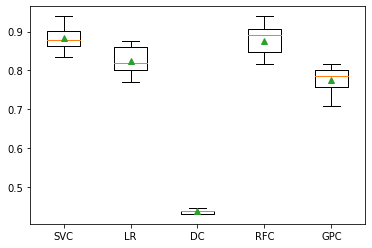

In [9]:
scores = [score_SVC_pc, score_LR_pc, score_DC_pc, score_RFC_pc, score_GPC_pc]
names = ['SVC','LR','DC','RFC','GPC']

plt.boxplot(scores, labels=names, showmeans = True)
plt.show()

(327, 7)


Text(0.5, 1.0, 'Scatter of Imbalanced Data')

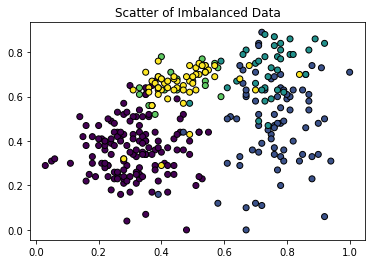

In [10]:
#scatter plot showing data before oversampling
encoder = LabelEncoder()
y_labels = encoder.fit_transform(Y)

print(X.shape)
plt.scatter(X['alm1'], X['mcg'], c=y_labels, edgecolors='k')
plt.title('Scatter of Imbalanced Data')

In [11]:
#oversample data using Random Over Sampler
ROS = RandomOverSampler()
X_sample_ROS, Y_sample_ROS = ROS.fit_resample(X, Y)

#oversample data using SMOTE
smote = SMOTE()
X_sample_SMOTE, Y_sample_SMOTE = smote.fit_resample(X, Y)

print(Counter(Y))
print(Counter(Y_sample_ROS))
print(Counter(Y_sample_SMOTE))


Counter({'cp': 143, 'im': 77, 'pp': 52, 'imU': 35, 'om': 20})
Counter({'cp': 143, 'im': 143, 'imU': 143, 'om': 143, 'pp': 143})
Counter({'cp': 143, 'im': 143, 'imU': 143, 'om': 143, 'pp': 143})


Text(0.5, 1.0, 'Over Sampling Using SMOTE')

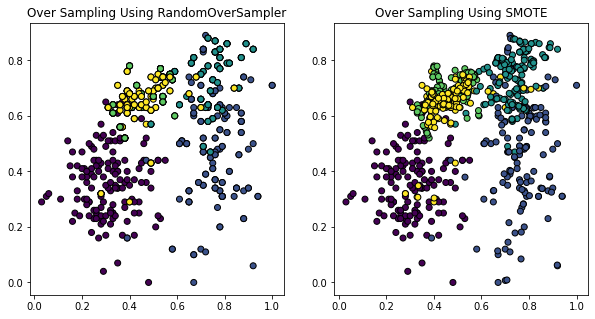

In [12]:
y_encoded_ros = encoder.fit_transform(Y_sample_ROS)
y_encoded_smote = encoder.fit_transform(Y_sample_SMOTE)

fig, axarr = plt.subplots(1,2, figsize=(10,5))

axarr[0].scatter(X_sample_ROS['alm1'], X_sample_ROS['mcg'], c=y_encoded_ros, edgecolors='k')
axarr[0].set_title('Over Sampling Using RandomOverSampler')

axarr[1].scatter(X_sample_SMOTE['alm1'], X_sample_SMOTE['mcg'], c=y_encoded_smote, edgecolors='k')
axarr[1].set_title('Over Sampling Using SMOTE')

In [13]:
score_OS_RFC = evaluate_model(X_sample_SMOTE, Y_sample_SMOTE, models[3])
print('RFC - Accuracy: %.2f (%.2f)' %(np.mean(score_OS_RFC), np.std(score_OS_RFC)))

RFC - Accuracy: 0.94 (0.01)


In [14]:
svc_balanced = SVC(kernel='rbf', class_weight='balanced')
score_OS_SVC = evaluate_model(X_sample_SMOTE, Y_sample_SMOTE, svc_balanced)
print('SVC - Accuracy: %.2f (%.2f)' %(np.mean(score_OS_SVC), np.std(score_OS_SVC)))

SVC - Accuracy: 0.92 (0.02)


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, '2-feature Scatter using SupportVectorClassifier')

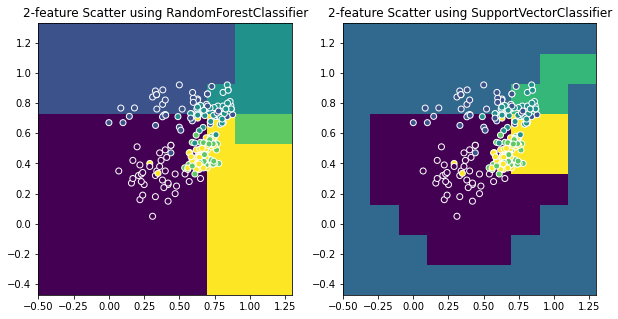

In [15]:
#build and train the model
idx1, idx2   = 0, 5
feat1, feat2 = 'mcg', 'alm1'

#select two features
X_sample_cpy = X_sample_SMOTE
X_sample_SMOTE = X_sample_SMOTE.iloc[:, [idx1,idx2]]
x_train, x_test, y_train, y_test = train_test_split(X_sample_SMOTE, encoder.fit_transform(Y_sample_SMOTE), test_size = 0.3, random_state = 0)

#build and train models
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

svc = SVC()
svc.fit(x_train, y_train)

x_min, x_max = x_train[feat1].min() - 0.5, x_train[feat1].max() + 0.5
y_min, y_max = x_train[feat2].min() - 0.5, x_train[feat2].max() + 0.5
step_size = 0.2

xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                     np.arange(y_min, y_max, step_size))

mesh_rfc = rfc.predict(np.c_[xx.ravel(), yy.ravel()])
mesh_svc = svc.predict(np.c_[xx.ravel(), yy.ravel()])

mesh_rfc = mesh_rfc.reshape(xx.shape)
mesh_svc = mesh_svc.reshape(xx.shape)

fig, axarr = plt.subplots(1,2, figsize=(10,5))

axarr[0].pcolormesh(xx,yy, mesh_rfc)
axarr[0].scatter(x_test[feat1], x_test[feat2], c=y_test,edgecolors='w')
axarr[0].set_title('2-feature Scatter using RandomForestClassifier')

axarr[1].pcolormesh(xx,yy, mesh_svc)
axarr[1].scatter(x_test[feat1], x_test[feat2], c=y_test,edgecolors='w')
axarr[1].set_title('2-feature Scatter using SupportVectorClassifier')

In [16]:
y_pred_rfc = rfc.predict(x_test)
print('RANDOM FOREST CLASSIFIER REPORT -------------------------------------------')
print(classification_report(y_test, y_pred_rfc, target_names = ['cp','im','imU','om','pp']))

RANDOM FOREST CLASSIFIER REPORT -------------------------------------------
              precision    recall  f1-score   support

          cp       0.85      0.92      0.88        37
          im       0.85      0.77      0.80        43
         imU       0.83      0.86      0.85        51
          om       0.67      0.56      0.61        43
          pp       0.51      0.59      0.55        41

    accuracy                           0.74       215
   macro avg       0.74      0.74      0.74       215
weighted avg       0.74      0.74      0.74       215



In [17]:
y_pred_svc = svc.predict(x_test)
print('SUPPORT VECTOR CLASSIFIER REPORT ------------------------------------------')
print(classification_report(y_test, y_pred_svc, target_names = ['cp','im','imU','om','pp']))

SUPPORT VECTOR CLASSIFIER REPORT ------------------------------------------
              precision    recall  f1-score   support

          cp       0.86      0.97      0.91        37
          im       0.91      0.67      0.77        43
         imU       0.77      0.90      0.83        51
          om       0.60      0.49      0.54        43
          pp       0.52      0.59      0.55        41

    accuracy                           0.73       215
   macro avg       0.73      0.72      0.72       215
weighted avg       0.73      0.73      0.72       215



In [18]:
#train RFC model using all features
x_train, x_test, y_train, y_test = train_test_split(X_sample_cpy, encoder.fit_transform(Y_sample_SMOTE), test_size = 0.2, random_state = 0)

#build and train model
rfc_all = RandomForestClassifier()
rfc_all.fit(x_train, y_train)
y_pred = rfc_all.predict(x_test)

print('7-feature RFC Accuracy Report -----------------------------------------')
print(classification_report(y_test, y_pred, target_names = ['cp','im','imU','om','pp']))

7-feature RFC Accuracy Report -----------------------------------------
              precision    recall  f1-score   support

          cp       0.96      1.00      0.98        25
          im       0.82      0.85      0.84        27
         imU       0.88      0.88      0.88        33
          om       0.97      1.00      0.98        30
          pp       1.00      0.89      0.94        28

    accuracy                           0.92       143
   macro avg       0.93      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



In [19]:
import pickle

pickle.dump(rfc_all, open('class_model.pkl','wb'))

model = pickle.load(open('class_model.pkl', 'rb'))

y_pred = model.predict(x_test)

print('7-feature RFC Accuracy Report -----------------------------------------')
print(classification_report(y_test, y_pred, target_names = ['cp','im','imU','om','pp']))

7-feature RFC Accuracy Report -----------------------------------------
              precision    recall  f1-score   support

          cp       0.96      1.00      0.98        25
          im       0.82      0.85      0.84        27
         imU       0.88      0.88      0.88        33
          om       0.97      1.00      0.98        30
          pp       1.00      0.89      0.94        28

    accuracy                           0.92       143
   macro avg       0.93      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143



In [20]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import mlflow

#Enter details of your AML workspace
subscription_id = 'fbde0a47-61ae-44b5-a95c-f594c77e1f94'
resource_group = 'devlab-ai-innovation-rg'
workspace = 'ml_dev'

#get a handle to the workspace
ml_client = MLClient(DefaultAzureCredential(), subscription_id, resource_group, workspace)

tracking_uri = ml_client.workspaces.get(name=workspace).mlflow_tracking_uri

mlflow.set_tracking_uri(tracking_uri)

print(tracking_uri)

EnvironmentCredential.get_token failed: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.


azureml://canadacentral.api.azureml.ms/mlflow/v1.0/subscriptions/fbde0a47-61ae-44b5-a95c-f594c77e1f94/resourceGroups/devlab-ai-innovation-rg/providers/Microsoft.MachineLearningServices/workspaces/ml_dev


In [21]:
experiment_name = 'experiment_with_mlflow'
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='', experiment_id='9303d3d4-25aa-4b1a-ab50-a8a8779a8b9a', lifecycle_stage='active', name='experiment_with_mlflow', tags={}>

In [22]:
import os
from random import random

with mlflow.start_run() as mlflow_run:
    mlflow.log_param("custom_param", "This is a test")
    mlflow.log_metric("custom_metric", 2)
    mlflow.log_artifact('class_model.pkl')